In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler,OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate
from sklearn.feature_selection import VarianceThreshold 

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


In [2]:
data = pd.read_csv('./cache/3-all_cat_clean.csv')
data

,ODATEDW,AGE,NUMCHLD,HIT,MBCRAFT,MBGARDEN,MBBOOKS,MBCOLECT,MAGFAML,MAGFEM,...,DOMAIN_A,NOEXCH,DOMAIN_B,TCODE,DOB,INCOME,WEALTH1,HPHONE_D,RFA_2F,CLUSTER2
0,8901,60.000000,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,T,0,2,0,3712,5.0,9.0,0,4,39.0
1,9401,46.000000,1.0,16,0.0,0.0,3.0,1.0,1.0,1.0,...,S,0,1,1,5202,6.0,9.0,0,2,1.0
2,9001,61.611649,3.0,2,0.0,0.0,1.0,0.0,0.0,0.0,...,R,0,2,1,0,3.0,1.0,1,4,60.0
3,8701,70.000000,1.0,2,0.0,0.0,0.0,0.0,0.0,0.0,...,R,0,2,0,2801,1.0,4.0,1,4,41.0
4,8601,78.000000,1.0,60,1.0,0.0,9.0,0.0,4.0,1.0,...,S,0,2,0,2001,3.0,2.0,1,2,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,9601,61.611649,3.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,C,0,2,1,0,6.0,8.0,0,1,12.0
95408,9601,48.000000,1.0,1,0.0,0.0,1.0,0.0,0.0,0.0,...,C,0,1,1,5001,7.0,9.0,1,1,2.0
95409,9501,60.000000,6.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,C,0,3,1,3801,3.0,5.0,1,3,34.0
95410,8601,58.000000,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,C,0,1,0,4005,7.0,3.0,1,4,11.0


In [3]:
# Filter out numerical and cat columns
numerical_data = data.select_dtypes(include=['number'])
print(numerical_data.shape)
# categorical_features = data.select_dtypes(include=['object'])

# Calculate the correlation
correlation_matrix = numerical_data.corr()

# Extract the correlation of features with the target variable
target_correlation = correlation_matrix['TARGET_D'].sort_values(ascending=False)

(95412, 336)


In [4]:
strong_correlations = target_correlation[target_correlation > 0.03]
strong_correlations = strong_correlations.keys().tolist()

In [5]:
numerical_data = numerical_data[strong_correlations]
numerical_data.shape

(95412, 22)

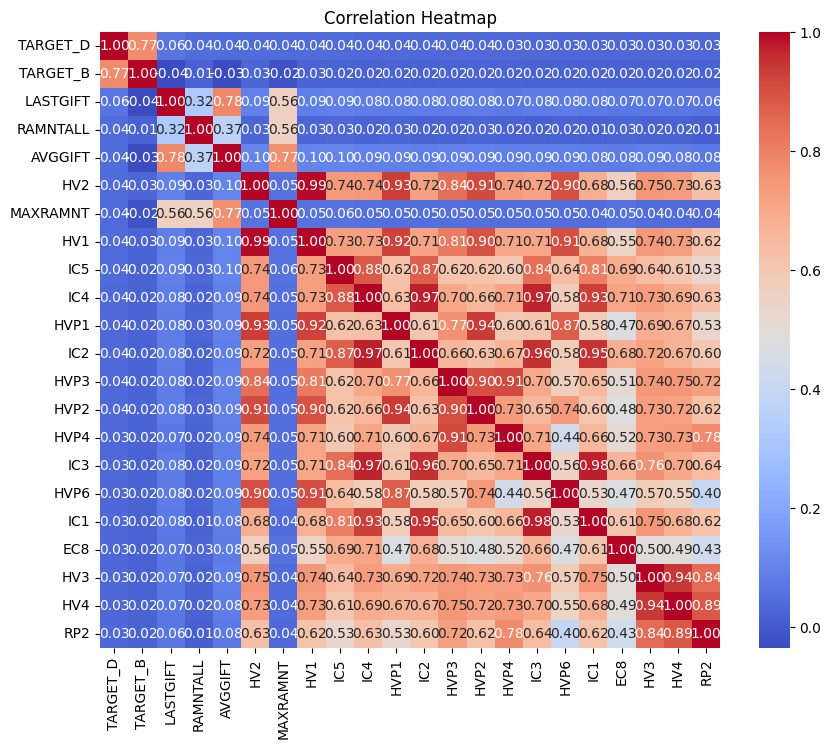

In [6]:
# Plot the heatmap
correlation_matrix = numerical_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

>> check categoricals, drop with cardinality

In [7]:
# Select categorical columns
categorical_data = data.select_dtypes(include='object')

# Calculate the number of unique values in each categorical variable
unique_value_counts = categorical_data.nunique()

# Get the names of categorical columns with cardinality greater than 15
high_cardinality_columns = unique_value_counts[unique_value_counts > 15].index.tolist()

# Drop the columns with high cardinality from the DataFrame
categorical_data = categorical_data.drop(columns=high_cardinality_columns)
categorical_data

,STATE,MAILCODE,HOMEOWNR,GENDER,DATASRCE,RFA_2,RFA_2R,RFA_2A,GEOCODE2,DOMAIN_A
0,IL,A,U,F,U,L4E,L,E,C,T
1,CA,A,H,M,3,L2G,L,G,A,S
2,NC,A,U,M,3,L4E,L,E,C,R
3,CA,A,U,F,3,L4E,L,E,C,R
4,FL,A,H,F,3,L2F,L,F,A,S
...,...,...,...,...,...,...,...,...,...,...
95407,other,A,U,M,U,L1G,L,G,C,C
95408,TX,A,H,M,3,L1F,L,F,A,C
95409,MI,A,U,M,U,L3E,L,E,B,C
95410,CA,A,H,F,2,L4F,L,F,A,C


> check data

In [8]:
display(numerical_data)
display(categorical_data)

,TARGET_D,TARGET_B,LASTGIFT,RAMNTALL,AVGGIFT,HV2,MAXRAMNT,HV1,IC5,IC4,...,HVP3,HVP2,HVP4,IC3,HVP6,IC1,EC8,HV3,HV4,RP2
0,0.0,0,10.0,240.0,7.741935,635,12.0,479,12883,378,...,13,7,27,349,0,307,3,3,2,5
1,0.0,0,25.0,47.0,15.666667,5218,25.0,5468,36175,1037,...,98,98,98,1026,94,1088,20,12,10,91
2,0.0,0,5.0,202.0,7.481481,546,16.0,497,11576,340,...,6,1,18,292,0,251,3,2,1,2
3,0.0,0,10.0,109.0,6.812500,1263,11.0,1000,15130,423,...,50,25,69,396,10,386,5,2,1,8
4,0.0,0,15.0,254.0,6.864865,594,15.0,576,9836,321,...,2,1,16,293,0,240,5,4,3,58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,0.0,0,25.0,25.0,25.000000,1025,25.0,988,18807,535,...,49,10,73,499,0,433,8,6,6,84
95408,0.0,0,20.0,20.0,20.000000,1723,20.0,1679,26538,849,...,88,71,91,802,5,806,14,3,3,26
95409,0.0,0,10.0,58.0,8.285714,377,10.0,376,12178,345,...,0,0,1,319,0,263,0,4,3,34
95410,18.0,1,18.0,498.0,12.146341,2459,21.0,2421,15948,556,...,99,96,99,568,9,552,5,11,10,88


,STATE,MAILCODE,HOMEOWNR,GENDER,DATASRCE,RFA_2,RFA_2R,RFA_2A,GEOCODE2,DOMAIN_A
0,IL,A,U,F,U,L4E,L,E,C,T
1,CA,A,H,M,3,L2G,L,G,A,S
2,NC,A,U,M,3,L4E,L,E,C,R
3,CA,A,U,F,3,L4E,L,E,C,R
4,FL,A,H,F,3,L2F,L,F,A,S
...,...,...,...,...,...,...,...,...,...,...
95407,other,A,U,M,U,L1G,L,G,C,C
95408,TX,A,H,M,3,L1F,L,F,A,C
95409,MI,A,U,M,U,L3E,L,E,B,C
95410,CA,A,H,F,2,L4F,L,F,A,C


In [9]:
# concat 
data = pd.concat([numerical_data, categorical_data], axis=1)
data

,TARGET_D,TARGET_B,LASTGIFT,RAMNTALL,AVGGIFT,HV2,MAXRAMNT,HV1,IC5,IC4,...,STATE,MAILCODE,HOMEOWNR,GENDER,DATASRCE,RFA_2,RFA_2R,RFA_2A,GEOCODE2,DOMAIN_A
0,0.0,0,10.0,240.0,7.741935,635,12.0,479,12883,378,...,IL,A,U,F,U,L4E,L,E,C,T
1,0.0,0,25.0,47.0,15.666667,5218,25.0,5468,36175,1037,...,CA,A,H,M,3,L2G,L,G,A,S
2,0.0,0,5.0,202.0,7.481481,546,16.0,497,11576,340,...,NC,A,U,M,3,L4E,L,E,C,R
3,0.0,0,10.0,109.0,6.812500,1263,11.0,1000,15130,423,...,CA,A,U,F,3,L4E,L,E,C,R
4,0.0,0,15.0,254.0,6.864865,594,15.0,576,9836,321,...,FL,A,H,F,3,L2F,L,F,A,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,0.0,0,25.0,25.0,25.000000,1025,25.0,988,18807,535,...,other,A,U,M,U,L1G,L,G,C,C
95408,0.0,0,20.0,20.0,20.000000,1723,20.0,1679,26538,849,...,TX,A,H,M,3,L1F,L,F,A,C
95409,0.0,0,10.0,58.0,8.285714,377,10.0,376,12178,345,...,MI,A,U,M,U,L3E,L,E,B,C
95410,18.0,1,18.0,498.0,12.146341,2459,21.0,2421,15948,556,...,CA,A,H,F,2,L4F,L,F,A,C


> filter data on TARGET_B

In [10]:

data = data[data['TARGET_B'] == 1]
data.drop(columns=['TARGET_B'], inplace=True)
# Shuffle the combined data
data = shuffle(data, random_state=42)
data.reset_index(drop=True, inplace=True)
data

/var/folders/pr/f4jl4tln3yn9fd_1yjrwwkp40000gn/T/ipykernel_77333/3074648477.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=['TARGET_B'], inplace=True)


,TARGET_D,LASTGIFT,RAMNTALL,AVGGIFT,HV2,MAXRAMNT,HV1,IC5,IC4,HVP1,...,STATE,MAILCODE,HOMEOWNR,GENDER,DATASRCE,RFA_2,RFA_2R,RFA_2A,GEOCODE2,DOMAIN_A
0,20.0,27.0,238.0,26.444444,649,28.0,518,12898,311,0,...,IL,A,H,F,3,L1G,L,G,D,T
1,10.0,10.0,263.0,10.115385,686,15.0,677,12509,313,0,...,FL,A,H,M,3,L1E,L,E,B,C
2,25.0,15.0,69.0,11.500000,500,15.0,500,19609,379,0,...,TX,A,U,F,U,L1F,L,F,A,C
3,10.0,17.0,47.0,15.666667,301,20.0,274,9658,232,0,...,other,A,H,M,3,L2F,L,F,D,R
4,6.0,8.0,202.0,6.312500,1036,15.0,827,12413,319,8,...,NC,A,U,M,U,L4E,L,E,C,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4838,25.0,20.0,20.0,20.000000,689,20.0,650,12679,342,1,...,other,A,U,M,U,L1F,L,F,D,R
4839,10.0,10.0,150.0,6.000000,1790,10.0,1801,19928,630,35,...,WA,A,H,other,3,L1E,L,E,A,S
4840,20.0,20.0,70.0,14.000000,816,25.0,567,17087,531,4,...,TX,A,U,F,U,L1F,L,F,C,R
4841,8.0,5.0,1622.0,23.852941,489,1000.0,476,10581,304,0,...,other,A,U,F,2,L4E,L,E,D,R


> train-test-split

In [11]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['TARGET_D'])  
y = data['TARGET_D']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
X_train_num   = X_train.select_dtypes(np.number)
X_test_num    = X_test.select_dtypes(np.number)
X_train_cat = X_train.select_dtypes(object) 
X_test_cat  = X_test.select_dtypes(object) 

In [13]:
# Scale numerical features
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_num), columns=X_train_num.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_num), columns=X_train_num.columns)

# Encode categorical features
encoder = OrdinalEncoder()
X_train_encoded = pd.DataFrame(encoder.fit_transform(X_train_cat), columns=X_train_cat.columns)
X_test_encoded = pd.DataFrame(encoder.transform(X_test_cat), columns=X_test_cat.columns)

X_train=pd.concat([X_train_scaled, X_train_encoded],axis=1)
X_test=pd.concat([X_test_scaled,X_test_encoded],axis=1)

>> finding the best model

In [14]:
max_depth = range(1,30)
test = []
train = []

for depth in max_depth:
    model = RandomForestRegressor(max_depth=depth, random_state=0)
    model.fit(X_train, y_train)
    test.append(model.score(X_test,y_test))
    train.append(model.score(X_train,y_train))

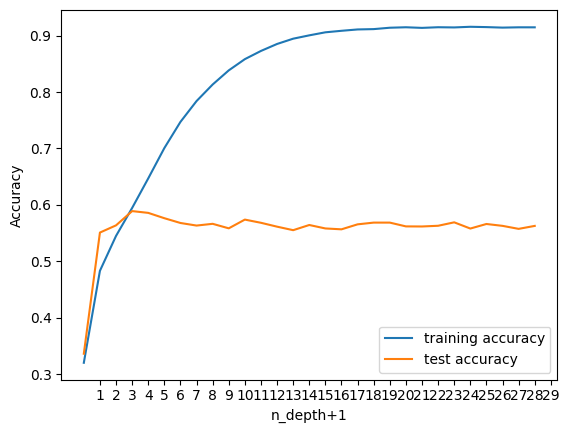

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot( train, label="training accuracy")
plt.plot( test, label="test accuracy")
plt.xticks(max_depth)
plt.ylabel("Accuracy")
plt.xlabel("n_depth+1")
plt.legend()

In [16]:
model_list=[LinearRegression(),KNeighborsRegressor(),DecisionTreeRegressor(max_depth=2),RandomForestRegressor(max_depth=3)]

In [17]:
def get_model_scored(models, X_tr, y_tr,X_te, y_te):
    for model in models:
        model.fit(X_tr, y_tr)
        print(f"{model.__class__.__name__}: Train: {model.score(X_tr, y_tr)}, Test: {model.score(X_te, y_te)}")

In [18]:
get_model_scored(model_list,X_train,y_train,X_test,y_test)

LinearRegression: Train: 0.4646309808792959, Test: 0.6459765466304899
KNeighborsRegressor: Train: 0.5339682888654562, Test: 0.26430038266014366
DecisionTreeRegressor: Train: 0.4489678621768284, Test: 0.48825358104019123
RandomForestRegressor: Train: 0.5461140718897102, Test: 0.6065325731750134


**LinearRegression: Train: 0.4657592998187424, Test: 0.6401878763037905**  
KNeighborsRegressor: Train: 0.5066020990711471, Test: 0.3996490760583361  
DecisionTreeRegressor: Train: 0.4549253574413975, Test: 0.4088768121822669  
**RandomForestRegressor: Train: 0.5543370381153354, Test: 0.5138832053007487**

>> Random Forest or Linear?

>>> max depth 3!

In [19]:
model = RandomForestRegressor(max_depth=3, random_state=0)
model.fit(X_train, y_train)
print(model.score(X_test,y_test))
print(model.score(X_train,y_train))

0.5637282382864273
0.545014909319864


> cross validation

In [20]:
def validate_model(models, X_tr, y_tr):
    for model in models:
        results= cross_validate(model,X_tr,y_tr,cv=5)
        print(f"Results for {model.__class__.__name__}:")
        print('Test scores: ', results['test_score'])
        print('Mean:', results['test_score'].mean(), '\n')

In [21]:
model_list=[LinearRegression(),RandomForestRegressor(max_depth=3)]
validate_model(model_list,X_train,y_train)

Results for LinearRegression:
Test scores:  [ 0.55935528  0.36259569 -0.0257108   0.19114235  0.43781439]
Mean: 0.30503937974295026 

Results for RandomForestRegressor:
Test scores:  [0.59700701 0.41882587 0.37820875 0.47868423 0.47981899]
Mean: 0.4705089700834225 



> create model 

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Instantiate RandomForestRegressor with optional hyperparameters
rf_regressor = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=42)

# Fit the model to the training data
rf_regressor.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = rf_regressor.predict(X_test_scaled)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("R-squared:", r2)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)


R-squared: 0.5981346027132797
Mean Absolute Error: 4.20939697648029
Root Mean Squared Error: 7.850437982195311


In [32]:
X = data.drop(columns=['TARGET_D'])  
y = data['TARGET_D'] 

numerical_features = X.select_dtypes(include=['int', 'float']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Split the data into numerical and categorical dataframes
X_numerical = X[numerical_features]
X_categorical = X[categorical_features]

In [34]:
# Scale the numerical features using the previously fitted scaler
X_numerical_scaled = scaler.transform(X_numerical)

# Encode the categorical features using the previously fitted encoder
X_categorical_encoded = encoder.transform(X_categorical)

# Convert the encoded array to a DataFrame
X_categorical_encoded_df = pd.DataFrame(X_categorical_encoded, columns=X_categorical.columns)

# Concatenate the scaled numerical features and encoded categorical features
X_scaled_encoded = pd.concat([pd.DataFrame(X_numerical_scaled, columns=X_numerical.columns), X_categorical_encoded_df], axis=1)

In [36]:
X_scaled_encoded

,LASTGIFT,RAMNTALL,AVGGIFT,HV2,MAXRAMNT,HV1,IC5,IC4,HVP1,IC2,...,STATE,MAILCODE,HOMEOWNR,GENDER,DATASRCE,RFA_2,RFA_2R,RFA_2A,GEOCODE2,DOMAIN_A
0,0.060000,0.102059,0.054013,0.109167,0.023116,0.086593,0.073904,0.223099,0.000000,0.174000,...,3.0,0.0,0.0,0.0,2.0,2.0,0.0,3.0,3.0,3.0
1,0.022222,0.113501,0.017543,0.115391,0.010050,0.113173,0.071675,0.224534,0.000000,0.181333,...,1.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,1.0,0.0
2,0.033333,0.024714,0.020635,0.084104,0.010050,0.083584,0.112358,0.271879,0.000000,0.210667,...,8.0,0.0,1.0,0.0,3.0,1.0,0.0,2.0,0.0,0.0
3,0.037778,0.014645,0.029941,0.050631,0.015075,0.045804,0.055339,0.166428,0.000000,0.124000,...,11.0,0.0,0.0,1.0,2.0,4.0,0.0,2.0,3.0,1.0
4,0.017778,0.085584,0.009049,0.174264,0.010050,0.138248,0.071125,0.228838,0.080808,0.183333,...,7.0,0.0,1.0,1.0,3.0,11.0,0.0,1.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4838,0.044444,0.002288,0.039619,0.115896,0.015075,0.108659,0.072649,0.245337,0.010101,0.188667,...,11.0,0.0,1.0,1.0,3.0,1.0,0.0,2.0,3.0,1.0
4839,0.022222,0.061785,0.008351,0.301093,0.005025,0.301070,0.114186,0.451937,0.353535,0.400667,...,9.0,0.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,2.0
4840,0.044444,0.025172,0.026219,0.137258,0.020101,0.094784,0.097907,0.380918,0.040404,0.266000,...,8.0,0.0,1.0,0.0,3.0,1.0,0.0,2.0,2.0,1.0
4841,0.011111,0.735469,0.048225,0.082254,1.000000,0.079572,0.060628,0.218077,0.000000,0.182667,...,11.0,0.0,1.0,0.0,1.0,11.0,0.0,1.0,3.0,1.0


In [37]:
rf_regressor = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=42)

# Train the model using the scaled and encoded features
rf_regressor.fit(X_scaled_encoded, y)

RandomForestRegressor(max_depth=3, random_state=42)

In [41]:
model_file_path = 'd_random_forest_regressor_model.pkl'
scaler_file_path = 'd_scaler.pkl'
encoder_file_path = 'd_encoder.pkl'

# Pickle the trained model
with open(model_file_path, 'wb') as file:
    pickle.dump(rf_regressor, file)
    
# Pickle the scaler
with open(scaler_file_path, 'wb') as file:
    pickle.dump(scaler, file)

# Pickle the encoder
with open(encoder_file_path, 'wb') as file:
    pickle.dump(encoder, file)